<h1> Empirical estimation of IPMs (integral probability metrics)<span class="tocSkip"></span></h1>

Author: [Sylvain Combettes](https://github.com/sylvaincom).

Last update: Jan 29, 2020.

---
This notebook deals with the empirical estimation of IPMs (integral probability metrics) and completes my report on the _Comparison of empirical probability distributions_. As $f$-divergences work on probability distributions, IPMs work on samples drawn from the probability distributions. Actually, for IPMs, we only focus on the Kantorovich metric.

If needed, see `ipm-prerequisite.ipynb` which introduces the `PuLP` library for solving linear programming problems and gives more details about how the Kantorovich function was built.

<br/>

<div class="alert alert-info"><h4>README<span class="tocSkip"></span></h4><p>
The best way to open this Jupyter Notebook is to use the table of contents from the extensions called <code>nbextensions</code>. See <a href="https://towardsdatascience.com/4-awesome-tips-for-enhancing-jupyter-notebooks-4d8905f926c5">4 Awesome Tips for Enhancing Jupyter Notebooks</a> by George Seif.

In your current directory:
- create a `img` folder (in which the generated images will be saved)
- create another `data` folder in move the download the [data from my GitHub](https://github.com/sylvaincom/comparison-distributions/tree/master/data) into it

The Python version is 3.7.3.
</p></div>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Defining-a-generic-function-for-computing-the-estimate-of-the-Kantorovich-metric-$W$" data-toc-modified-id="Defining-a-generic-function-for-computing-the-estimate-of-the-Kantorovich-metric-$W$-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Defining a generic function for computing the estimate of the Kantorovich metric $W$</a></span><ul class="toc-item"><li><span><a href="#Defining-the-generic-function" data-toc-modified-id="Defining-the-generic-function-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Defining the generic function</a></span></li><li><span><a href="#The-memory-error-due-to-the-linear-programming-problem" data-toc-modified-id="The-memory-error-due-to-the-linear-programming-problem-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>The memory error due to the linear programming problem</a></span></li></ul></li><li><span><a href="#Running-several-simulations-to-interpret-$W$" data-toc-modified-id="Running-several-simulations-to-interpret-$W$-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Running several simulations to interpret $W$</a></span><ul class="toc-item"><li><span><a href="#Comparing-two-normal-distributions" data-toc-modified-id="Comparing-two-normal-distributions-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Comparing two normal distributions</a></span><ul class="toc-item"><li><span><a href="#Influence-of-the-difference-of-means-$\mu_q-\mu_p$-on-$W$" data-toc-modified-id="Influence-of-the-difference-of-means-$\mu_q-\mu_p$-on-$W$-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Influence of the difference of means $\mu_q-\mu_p$ on $W$</a></span></li><li><span><a href="#Influence-of-the-difference-of-standard-deviations-$\sigma_q-\sigma_p$-on-$W$" data-toc-modified-id="Influence-of-the-difference-of-standard-deviations-$\sigma_q-\sigma_p$-on-$W$-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>Influence of the difference of standard deviations $\sigma_q-\sigma_p$ on $W$</a></span></li></ul></li><li><span><a href="#Comparison-of-two-exponential-distributions" data-toc-modified-id="Comparison-of-two-exponential-distributions-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Comparison of two exponential distributions</a></span></li><li><span><a href="#Comparison-of-two-uniform-distributions" data-toc-modified-id="Comparison-of-two-uniform-distributions-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Comparison of two uniform distributions</a></span></li></ul></li><li><span><a href="#Application-of-the-Kantorovich-metric-to-the-data-generated-from-two-methods-for-computing-the-Choquet-integral" data-toc-modified-id="Application-of-the-Kantorovich-metric-to-the-data-generated-from-two-methods-for-computing-the-Choquet-integral-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Application of the Kantorovich metric to the data generated from two methods for computing the Choquet integral</a></span><ul class="toc-item"><li><span><a href="#For-the-Choquet-integral-of-normal-distributions" data-toc-modified-id="For-the-Choquet-integral-of-normal-distributions-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>For the Choquet integral of normal distributions</a></span></li></ul></li></ul></div>

<h2> Imports<span class="tocSkip"></span></h2>

In [1]:
# pip install pulp
from pulp import *

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
from sklearn.linear_model import LinearRegression

from time import process_time
import datetime

import random

We configure the size of the plots:

In [2]:
plt.rcParams["figure.figsize"] = (8,6)

# Defining a generic function for computing the estimate of the Kantorovich metric $W$

## Defining the generic function

We duplicate the functions created in `ipm-prerequisite.ipynb`:

In [3]:
def construct_c(X_p, X_q):
    m = len(X_p)
    n = len(X_q)
    
    Y = [1/m]*m + [-1/n]*n
    
    return np.asarray(Y)


def rho(x,y):
    return abs(x-y)


def construct_b(X_p, X_q):
    
    X = np.concatenate((X_p, X_q), axis=0)
    N = len(X)
    
    b_part = []
    for i in range(N):
        for j in range(i+1, N):
            b_part.append(rho(X[i], X[j]))
    
    # Now, we duplicate each row to obtain a list of size 2*N
    b = []
    for i in range(N):
        b.append(b_part[i])
        b.append(b_part[i])
    
    return b


def construct_M(X_p, X_q):
    
    X = np.concatenate((X_p, X_q), axis=0)
    N = len(X)
    
    M = []
    for i in range(N):
        for j in range(i+1, N):
            l_M_1 = [0]*N
            l_M_1[i] = 1
            l_M_1[j] = -1
            M.append(l_M_1)
            l_M_2 = [0]*N
            l_M_2[i] = -1
            l_M_2[j] = 1
            M.append(l_M_2)
    M = np.asarray(M)

    return M.astype(int)

and we regroup them under one function:

In [4]:
def kantorovich_metric(X_p, X_q):
    
    X = np.concatenate((X_p, X_q), axis=0)
    m = len(X_p)
    n = len(X_q)
    N = m+n
    
    c = construct_c(X_p, X_q)
    b = construct_b(X_p, X_q)
    M = construct_M(X_p, X_q)
    
    prob = LpProblem("LP problem for estimating the Kantorovich metric", LpMaximize)
    a = LpVariable.matrix("a", list(range(N)))
    prob += lpDot(c, a)
    p = 2*N
    for i in range(p):
        prob += lpDot(M[i], a) <= b[i]
    prob.solve()
    
#     for v in prob.variables():
#         print(v.name, "=", v.varValue)
        
#     print("objective=", value(prob.objective))

    return value(prob.objective)

Now, we check if we obtain the same result as formula (II.11) of the report:

In [5]:
np.random.seed(1) # random seed for reproducability
X_p = np.random.uniform(1, 2, 10)
np.random.seed(2) # random seed for reproducability
X_q = np.random.uniform(9, 10, 10)
W = kantorovich_metric(X_p, X_q)
print('The empirical Kantorovich metric is: \n', W)

The empirical Kantorovich metric is: 
 8.1291911711


which is close to $8$.

## The memory error due to the linear programming problem

We take the same parameters as previsouly but with more samples:

In [6]:
t_start = process_time()
np.random.seed(1) # random seed for reproducability
X_p = np.random.uniform(1, 2, 100)
np.random.seed(2) # random seed for reproducability
X_q = np.random.uniform(9, 10, 100)
kantorovich_metric(X_p, X_q)
t_stop = process_time()
print('The empirical Kantorovich metric is: \n', W)
print('The processing time is: \n', datetime.timedelta(seconds=t_stop-t_start))

The empirical Kantorovich metric is: 
 8.1291911711
The processing time is: 
 0:00:02.069589


In [7]:
t_start = process_time()
np.random.seed(1) # random seed for reproducability
X_p = np.random.uniform(1, 2, 200)
np.random.seed(2) # random seed for reproducability
X_q = np.random.uniform(9, 10, 200)
W = kantorovich_metric(X_p, X_q)
t_stop = process_time()
print('The empirical Kantorovich metric is: \n', W)
print('The processing time is: \n', datetime.timedelta(seconds=t_stop-t_start))

The empirical Kantorovich metric is: 
 8.325250933285504
The processing time is: 
 0:00:09.772599


In [8]:
# t_start = process_time()
# np.random.seed(1) # random seed for reproducability
# X_p = np.random.uniform(1, 2, 300)
# np.random.seed(2) # random seed for reproducability
# X_q = np.random.uniform(9, 10, 300)
# W = kantorovich_metric(X_p, X_q)
# t_stop = process_time()
# print('The empirical Kantorovich metric is: \n', W)
# print('The processing time is: \n', datetime.timedelta(seconds=t_stop-t_start))

We obtained a memory error for $300$ samples per distribution !

The problem is that when we have more than $400$ total samples (for the two distributions), $M$ already has $400 \times 399 \times 400 = 63~840~000$ values and we have a memory problem if we go above $400$ total samples. Hence, we can not have more than $200$ samples per distribution.

Note that the problem is not really about the computing time (which of course, we could have tried to improve).

# Running several simulations to interpret $W$

Check how it evolves with the number of samples, compute the empirical standard deviation and mean.

## Comparing two normal distributions

Here we consider two normal distributions $\mathbb{P} = \mathcal{N}(\mu_p, \sigma_p)$ and $\mathbb{Q} = \mathcal{N}(\mu_q, \sigma_q)$.

### Influence of the difference of means $\mu_q-\mu_p$ on $W$

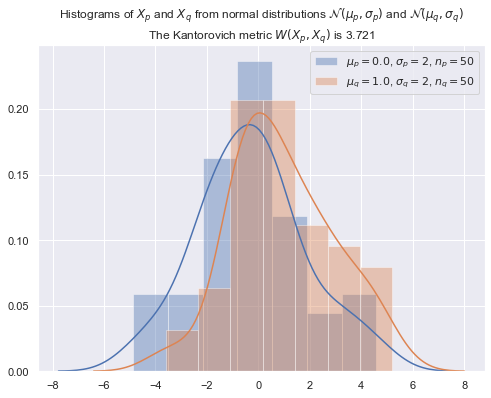

In [9]:
mu_p, sigma_p, n_p, mu_q, sigma_q, n_q = 0, 2, 50, 1, 2, 50
np.random.seed(2) # random seed for reproducability
X_p = np.random.normal(mu_p, sigma_p, n_p)
np.random.seed(1) # random seed for reproducability
X_q = np.random.normal(mu_q, sigma_q, n_q)

txt = 'Histograms of $X_p$ and $X_q$ from normal distributions '
txt = txt + '$\mathcal{N}(\mu_p, \sigma_p)$ and $\mathcal{N}(\mu_q, \sigma_q)$ \n'
txt = txt + 'The Kantorovich metric $W(X_p, X_q)$ is %1.3f' % kantorovich_metric(X_p, X_q)
plt.title(txt)
sns.distplot(X_p) ;
sns.distplot(X_q) ;
txt1 = '$\mu_p = %1.1f$, $\sigma_p = %1.0f$, $n_p= %1.0f$' % (mu_p, sigma_p, n_p)
txt2 = '$\mu_q = %1.1f$, $\sigma_q = %1.0f$, $n_q= %1.0f$' % (mu_q, sigma_q, n_q)
plt.legend([txt1, txt2]) ;
plt.savefig('img/IPM_normal_histo_1.png', dpi=120) ; # to save the figure

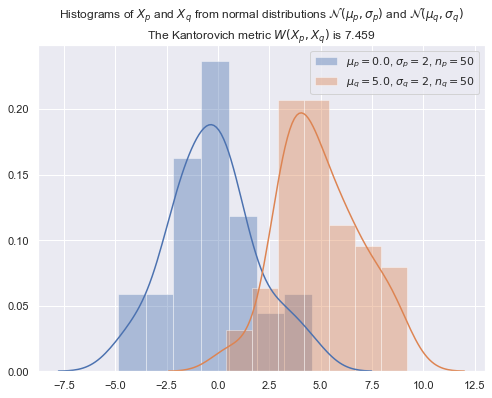

In [10]:
mu_p, sigma_p, n_p, mu_q, sigma_q, n_q = 0, 2, 50, 5, 2, 50
np.random.seed(2) # random seed for reproducability
X_p = np.random.normal(mu_p, sigma_p, n_p)
np.random.seed(1) # random seed for reproducability
X_q = np.random.normal(mu_q, sigma_q, n_q)

txt = 'Histograms of $X_p$ and $X_q$ from normal distributions '
txt = txt + '$\mathcal{N}(\mu_p, \sigma_p)$ and $\mathcal{N}(\mu_q, \sigma_q)$ \n'
txt = txt + 'The Kantorovich metric $W(X_p, X_q)$ is %1.3f' % kantorovich_metric(X_p, X_q)
plt.title(txt)
sns.distplot(X_p) ;
sns.distplot(X_q) ;
txt1 = '$\mu_p = %1.1f$, $\sigma_p = %1.0f$, $n_p= %1.0f$' % (mu_p, sigma_p, n_p)
txt2 = '$\mu_q = %1.1f$, $\sigma_q = %1.0f$, $n_q= %1.0f$' % (mu_q, sigma_q, n_q)
plt.legend([txt1, txt2]) ;
plt.savefig('img/IPM_normal_histo_2.png', dpi=120) ; # to save the figure

In [11]:
l_IPM_mu = []
l_diff_mu = []

mu_p = 0
sigma_p = 2
n_p = 30 # after several simulations, 30 seems enough
np.random.seed(1) # random seed for reproducability
X_p = np.random.normal(mu_p, sigma_p, n_p)

sigma_q = 2
n_q = n_p

l_abs = np.arange(0, 20+0.5, 0.5)
for mu_q in l_abs:
    np.random.seed(int(mu_q*10)) # random seed for reproducability, different each time
    X_q = np.random.normal(mu_q, sigma_q, n_q)
    l_diff_mu.append([mu_q-mu_p])
    l_IPM_mu.append([kantorovich_metric(X_p, X_q)])

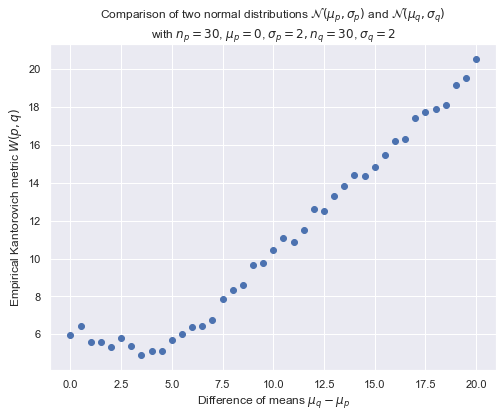

In [12]:
txt = 'Comparison of two normal distributions $\mathcal{N}(\mu_p, \sigma_p)$ and $\mathcal{N}(\mu_q, \sigma_q)$ \n'
txt = txt + 'with $n_p = %1.0f$, $\mu_p = %1.0f$, $\sigma_p = %1.0f, $' % (n_p, mu_p, sigma_p)
txt = txt + '$n_q = %1.0f$, $\sigma_q = %1.0f$' % (n_q, sigma_q)
plt.title(txt)
plt.xlabel('Difference of means $\mu_q-\mu_p$')
plt.ylabel('Empirical Kantorovich metric $W(p, q)$')
plt.plot(l_diff_mu, l_IPM_mu, 'o') ;
plt.savefig('img/IPM_normal_diff_mu.png', dpi=120) # to save the figure

Can we say that the dependency of $W(p,q)$ to $\mu_q-\mu_p$ is linear? Yes. Indeed, we have:

In [13]:
reg = LinearRegression()
X = np.power(np.asarray(l_diff_mu), 1)
y = np.asarray(l_IPM_mu)

reg.fit(X, y)
print('The regression score is: \n', round(reg.score(X, y), 3))
print('The regression coefficients are: \n', np.round(reg.coef_, 3))
print('The regression intercept is: \n', np.round(reg.intercept_, 3))

The regression score is: 
 0.946
The regression coefficients are: 
 [[0.807]]
The regression intercept is: 
 [2.877]


### Influence of the difference of standard deviations $\sigma_q-\sigma_p$ on $W$

In [14]:
l_IPM_sigma = []
l_diff_sigma = []

mu_p = 0
sigma_p = 2
n_p = 30 # after several simulations, 30 seems enough
np.random.seed(1) # random seed for reproducability
X_p = np.random.normal(mu_p, sigma_p, n_p)

mu_q = 0
n_q = n_p

l_abs = np.arange(0, 10, 0.25)
for sigma_q in l_abs:
    np.random.seed(int(sigma_q*10)) # random seed for reproducability, different each time
    X_q = np.random.normal(mu_q, sigma_q, n_q)
    l_diff_sigma.append([sigma_q-sigma_p])
    l_IPM_sigma.append([kantorovich_metric(X_p, X_q)])

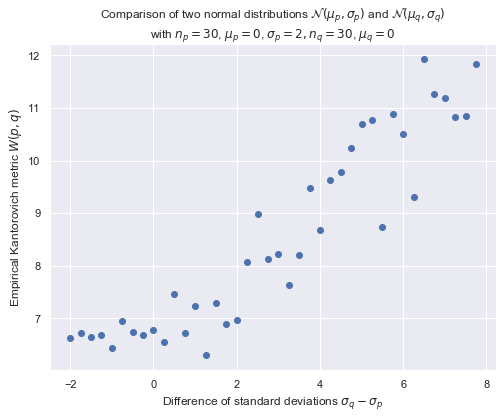

In [15]:
txt = 'Comparison of two normal distributions $\mathcal{N}(\mu_p, \sigma_p)$ and $\mathcal{N}(\mu_q, \sigma_q)$ \n'
txt = txt + 'with $n_p = %1.0f$, $\mu_p = %1.0f$, $\sigma_p = %1.0f, $' % (n_p, mu_p, sigma_p)
txt = txt + '$n_q = %1.0f$, $\mu_q = %1.0f$' % (n_q, mu_q)
plt.title(txt)
plt.xlabel('Difference of standard deviations $\sigma_q-\sigma_p$')
plt.ylabel('Empirical Kantorovich metric $W(p, q)$')
plt.plot(l_diff_sigma, l_IPM_sigma, 'o') ;
plt.savefig('img/IPM_normal_diff_sigma.png', dpi=120) # to save the figure

In [16]:
reg = LinearRegression()
X = np.power(np.asarray(l_diff_sigma), 1)
y = np.asarray(l_IPM_sigma)

reg.fit(X, y)
print('The regression score is: \n', round(reg.score(X, y), 3))
print('The regression coefficients are: \n', np.round(reg.coef_, 3))
print('The regression intercept is: \n', np.round(reg.intercept_, 3))

The regression score is: 
 0.856
The regression coefficients are: 
 [[0.573]]
The regression intercept is: 
 [6.891]


## Comparison of two exponential distributions


Here we consider two exponential distributions $\mathbb{P} = \mathcal{E}(\lambda_p)$ and $\mathbb{Q} = \mathcal{E}(\lambda_q)$.

In [17]:
l_IPM_lambda = []
l_diff_lambda = []

lambda_p = 0
n_p = 30 # after several simulations, 30 seems enough
np.random.seed(1) # random seed for reproducability
X_p = np.random.exponential(lambda_p, n_p)

n_q = n_p

l_abs = np.arange(0, 20, 0.5)
for lambda_q in l_abs:
    np.random.seed(int(lambda_q*10)) # random seed for reproducability, different each time
    X_q = np.random.exponential(lambda_q, n_q)
    l_diff_lambda.append([lambda_q-lambda_p])
    l_IPM_lambda.append([kantorovich_metric(X_p, X_q)])

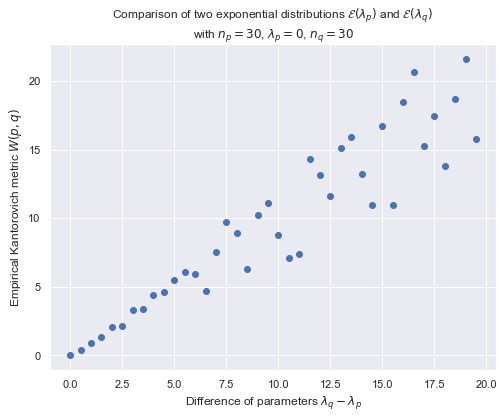

In [18]:
txt = 'Comparison of two exponential distributions $\mathcal{E}(\lambda_p)$ and $\mathcal{E}(\lambda_q)$ \n'
txt = txt + 'with $n_p = %1.0f$, $\lambda_p = %1.0f$, ' % (n_p, lambda_p)
txt = txt + '$n_q = %1.0f$' % (n_q)
plt.title(txt)
plt.xlabel('Difference of parameters $\lambda_q-\lambda_p$')
plt.ylabel('Empirical Kantorovich metric $W(p, q)$')
plt.plot(l_diff_lambda, l_IPM_lambda, 'o') ;
plt.savefig('img/IPM_exponential_diff.png', dpi=120) # to save the figure

In [19]:
reg = LinearRegression()
X = np.power(np.asarray(l_diff_lambda), 1)
y = np.asarray(l_IPM_lambda)

reg.fit(X, y)
print('The regression score is: \n', round(reg.score(X, y), 3))
print('The regression coefficients are: \n', np.round(reg.coef_, 3))
print('The regression intercept is: \n', np.round(reg.intercept_, 3))

The regression score is: 
 0.883
The regression coefficients are: 
 [[0.967]]
The regression intercept is: 
 [0.211]


## Comparison of two uniform distributions

Here we consider two normal distributions $\mathbb{P} = \mathbb{U}\left([a, a+h]\right)$ and $\mathbb{Q} = \mathbb{U}\left([r, r+h]\right)$ where $h$ is the length of the intervals.

Note: $a$ is called the **interval start** of $[a, a+h]$.

In [20]:
l_IPM_unif = []
l_diff_unif = []

h = 2 # length of the intervals
a = 0
b = a+h
n_p = 30 # after several simulations, 30 seems enough
np.random.seed(1) # random seed for reproducability
X_p = np.random.uniform(a, b, n_p)

n_q = n_p

l_abs = np.arange(0, 20, 0.5)
for r in l_abs:
    np.random.seed(int(r*10)) # random seed for reproducability, different each time
    X_q = np.random.uniform(r, r+h, n_q)
    l_diff_unif.append([r-a])
    l_IPM_unif.append([kantorovich_metric(X_p, X_q)])

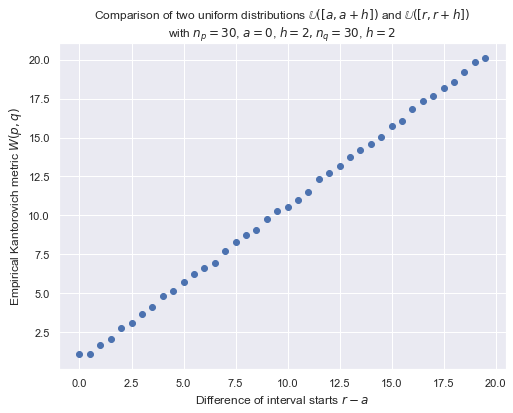

In [21]:
txt = 'Comparison of two uniform distributions $\mathbb{U}([a, a+h])$ and $\mathbb{U}([r, r+h])$ \n'
txt = txt + 'with $n_p = %1.0f$, $a = %1.0f$, $h = %1.0f, $' % (n_p, a, h)
txt = txt + '$n_q = %1.0f$, $h = %1.0f$' % (n_q, h)
plt.title(txt)
plt.xlabel('Difference of interval starts $r-a$')
plt.ylabel('Empirical Kantorovich metric $W(p, q)$')
plt.plot(l_diff_unif, l_IPM_unif, 'o') ;
plt.savefig('img/IPM_uniform_diff.png', dpi=120) # to save the figure

In [22]:
reg = LinearRegression()
X = np.power(np.asarray(l_diff_unif), 1)
y = np.asarray(l_IPM_unif)

reg.fit(X, y)
print('The regression score is: \n', round(reg.score(X, y), 3))
print('The regression coefficients are: \n', np.round(reg.coef_, 3))
print('The regression intercept is: \n', np.round(reg.intercept_, 3))

The regression score is: 
 1.0
The regression coefficients are: 
 [[0.998]]
The regression intercept is: 
 [0.693]


# Application of the Kantorovich metric to the data generated from two methods for computing the Choquet integral

## For the Choquet integral of normal distributions

In [23]:
X1_df = pd.read_csv('data/X1_normal.csv', sep=',', header=None)
X2_df = pd.read_csv('data/X2_normal.csv', sep=',', header=None)

X1_array = X1_df.values[0]
X2_array = X2_df.values[0]

X1_list = X1_df.values.tolist()
X2_list = X2_df.values.tolist()

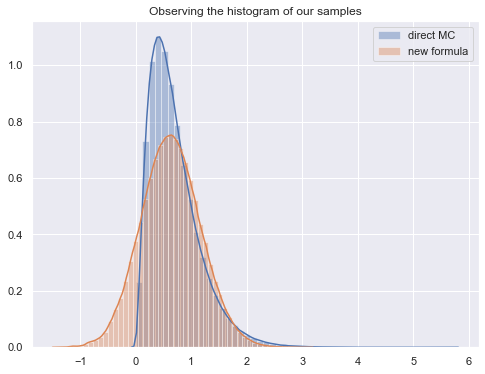

In [24]:
sns.distplot(X1_list) ;
sns.distplot(X2_list) ;
plt.title('Observing the histogram of our samples') ;
plt.legend(['direct MC', 'new formula']) ;
plt.savefig('img/choquet_normal_X.png', dpi=120) # to save the figure

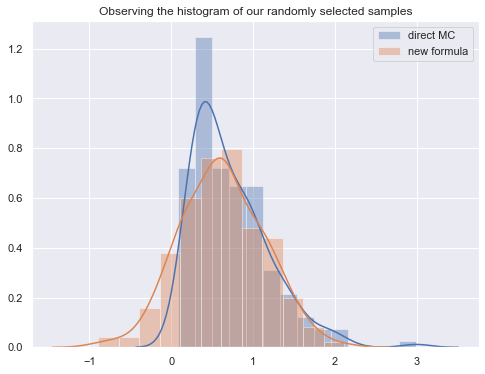

In [25]:
X1 = random.sample(X1_list, 200)
X2 = random.sample(X2_list, 200)

sns.distplot(X1) ;
sns.distplot(X2) ;
plt.title('Observing the histogram of our randomly selected samples') ;
plt.legend(['direct MC', 'new formula']) ;

In [26]:
kantorovich_metric(X1, X2)

1.1757630010000002